In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.metrics import *
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import load_img

import numpy as np
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import cv2

import os

In [ ]:
!pip install opendatasets --upgrade
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: pinky1234
Your Kaggle Key: ··········


100%|██████████| 778M/778M [00:30<00:00, 26.8MB/s]

In [ ]:
# Paths to images
covid_image_path = '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/'
normal_image_path = '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/'
pneumonia_image_path = '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/images/'
lung_opacity_image_path = '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/images/'

# Paths to masks
covid_mask_path = '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/masks/'
normal_mask_path = '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/masks/'
pneumonia_mask_path = '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/masks/'
lung_opacity_mask_path = '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/masks/'

# All paths to images and masks
all_image_paths = [[covid_image_path+file for file in os.listdir(covid_image_path)]
                   +[normal_image_path+file for file in os.listdir(normal_image_path)]
                   +[pneumonia_image_path+file for file in os.listdir(pneumonia_image_path)]
                   +[lung_opacity_image_path+file for file in os.listdir(lung_opacity_image_path)]
                  ][0]
all_mask_paths = [[covid_mask_path+file for file in os.listdir(covid_mask_path)]
                  +[normal_mask_path+file for file in os.listdir(normal_mask_path)]
                  +[pneumonia_mask_path+file for file in os.listdir(pneumonia_mask_path)]
                  +[lung_opacity_mask_path+file for file in os.listdir(lung_opacity_mask_path)]
                 ][0]

# Shuffle the arrays
all_image_paths, all_mask_paths = shuffle(all_image_paths, all_mask_paths)

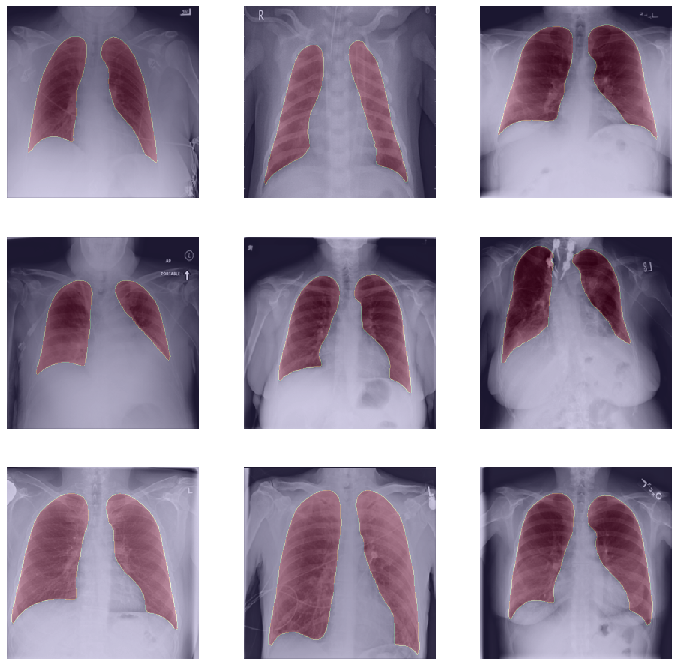

In [ ]:
IMAGE_SIZE = 256

def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = np.mean(image, axis=-1)/255.0
        images.append(image)
    return np.array(images)

fig = plt.figure(figsize=(12, 12))
c = 3
r = 3
for i in range(1, c*r +1):
    fig.add_subplot(r, c, i)
    plt.axis('off')
    plt.imshow(open_images([all_image_paths[i-1]])[0], cmap='gray', interpolation='none')
    plt.imshow(open_images([all_mask_paths[i-1]])[0], cmap='Spectral_r', alpha=0.3)
plt.show()

In [ ]:
train_image_paths = all_image_paths[:17000]
train_mask_paths = all_mask_paths[:17000]
val_image_paths = all_image_paths[17000:]
val_mask_paths = all_mask_paths[17000:]

def datagen(image_paths, mask_paths, batch_size=16):
    for x in range(0, len(image_paths), batch_size):
        images = open_images(image_paths[x:x+batch_size]).reshape(-1,IMAGE_SIZE, IMAGE_SIZE, 1)
        masks = open_images(mask_paths[x:x+batch_size]).reshape(-1,IMAGE_SIZE, IMAGE_SIZE, 1)
        yield images, masks

In [ ]:
img_input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))

x1 = Conv2D(64, (3,3), activation='relu', padding='same')(img_input)
x1 = Conv2D(64, (3,3), activation='relu', padding='same')(x1)
x1_pool = MaxPool2D((2,2))(x1)

x2 = Conv2D(128, (3,3), activation='relu', padding='same')(x1_pool)
x2 = Conv2D(128, (3,3), activation='relu', padding='same')(x2)
x2_pool = MaxPool2D((2,2))(x2)

x3 = Conv2D(256, (3,3), activation='relu', padding='same')(x2_pool)
x3 = Conv2D(256, (3,3), activation='relu', padding='same')(x3)
x3 = Conv2D(256, (3,3), activation='relu', padding='same')(x3)
x3_pool = MaxPool2D((2,2))(x3)

x4 = Conv2D(256, (3,3), activation='relu', padding='same')(x3_pool)
x4 = Conv2D(256, (3,3), activation='relu', padding='same')(x4)
x4 = Conv2D(256, (3,3), activation='relu', padding='same')(x4)
x4_pool = UpSampling2D((2,2))(x4)

x5 = Concatenate()([x4_pool, x3])
x5 = Conv2D(128, (3,3), activation='relu', padding='same')(x5)
x5 = Conv2D(128, (3,3), activation='relu', padding='same')(x5)
x5_pool = UpSampling2D((2,2))(x5)

x6 = Concatenate()([x5_pool, x2])
x6 = Conv2D(64, (3,3), activation='relu', padding='same')(x6)
x6 = Conv2D(64, (3,3), activation='relu', padding='same')(x6)
x6_pool = UpSampling2D((2,2))(x6)

x7 = Concatenate()([x6_pool, x1])
x7 = Conv2D(64, (3,3), activation='relu', padding='same')(x7)
x7 = Conv2D(64, (3,3), activation='relu', padding='same')(x7)
x7 = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x7)

model = Model(img_input, x7)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=["accuracy"])

In [ ]:
batch_size = 32
steps = int(len(train_image_paths)/batch_size)
epochs = 1
for _ in range(epochs):
    model.fit(datagen(train_image_paths, train_mask_paths, batch_size=batch_size), epochs=1, steps_per_epoch=steps)

531/531 [==============================] - 610s 1s/step - loss: 0.2099 - accuracy: 0.9091


In [ ]:
batch_size = 32
steps = int(len(val_image_paths)/batch_size)
model.evaluate(datagen(val_image_paths, val_mask_paths, batch_size=batch_size), steps=steps)

130/130 [==============================] - 48s 370ms/step - loss: 0.0932 - accuracy: 0.9642


[0.09324997663497925, 0.9642211198806763]

In [ ]:
def predict(images):
    pred = model.predict(images)
    pred[pred>=0.5] = 1
    pred[pred<0.5] = 0
    return pred

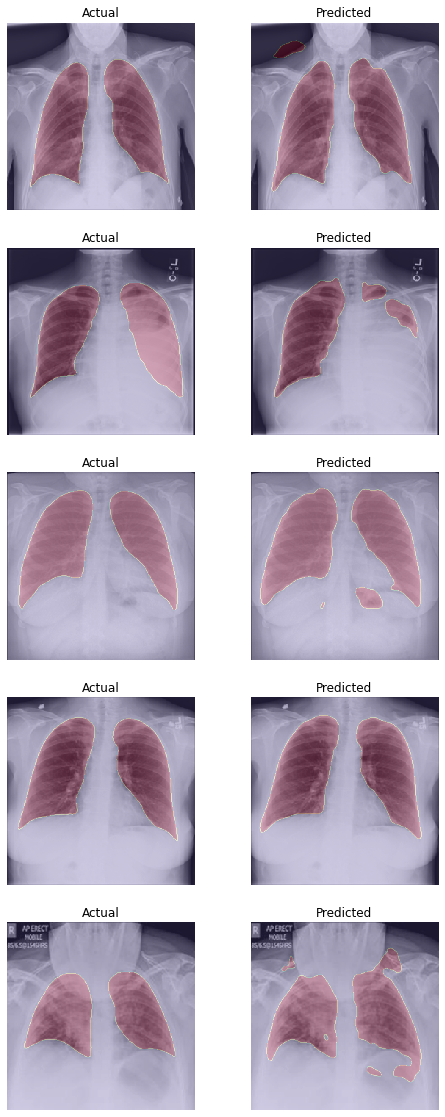

In [ ]:
NO_OF_SAMPLES = 5

c = 2
r = NO_OF_SAMPLES
fig = plt.figure(figsize=(8, r*4))
for i in range(1, c*r +1, 2):
    
    image = open_images([val_image_paths[i-1]]).reshape(-1,IMAGE_SIZE, IMAGE_SIZE, 1)
    mask = open_images([val_mask_paths[i-1]]).reshape(-1,IMAGE_SIZE, IMAGE_SIZE, 1)
    pred = predict(image)
    
    fig.add_subplot(r, c, i)
    plt.axis('off')
    plt.title('Actual')
    plt.imshow(np.squeeze(image[0]), cmap='gray', interpolation='none')
    plt.imshow(np.squeeze(mask[0]), cmap='Spectral_r', alpha=0.3)
    
    fig.add_subplot(r, c, i+1)
    plt.axis('off')
    plt.title('Predicted')
    plt.imshow(np.squeeze(image[0]), cmap='gray', interpolation='none')
    plt.imshow(np.squeeze(pred[0]), cmap='Spectral_r', alpha=0.3)
    
plt.show()

In [ ]:
model.save('lungs_seg.h5')